In [101]:
import os 

In [102]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [103]:
os.chdir("../.")

In [104]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [105]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [106]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    product_path: Path
    train_data_file: Path
    test_data_file: Path
    target_column: str
    joined_data_file: Path

In [107]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [108]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        schema =  self.schema.target_column
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            product_path= Path(config.product_path),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file),
            target_column= schema.name,
            joined_data_file= Path(config.joined_data_file)
            )
        
        
        return data_transformation_config
    

In [109]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

     


In [110]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        #self.data = None
        #self.transformed_data = None
        
    def join_datasets(self):
        """
        Join customer and product datasets"""    
        try:
            customer_data = pd.read_csv(self.config.customer_path)
            product_data = pd.read_csv(self.config.product_path)

            # Ensure the directory for saving exists
            output_dir = os.path.dirname(self.config.transformed_data_file)
            os.makedirs(output_dir, exist_ok=True)

            # Join operation
            joined_data = pd.merge(customer_data, product_data, how="left",
                                left_on="existing_products", right_on="product_name")
            
            #drop unnecessary columns
            joined_data = joined_data.drop(columns=['existing_products'], errors='ignore')  # Drop columns which are not needed if it exists
            
            #check the dataset head
            print(joined_data.head())
            
            
            # Save the joined data
            try:   
                joined_data.to_csv(self.config.joined_data_file, index=False)
                logger.info(f"Joined dataset saved to {self.config.joined_data_file}")
                print(f"Joined dataset saved to {self.config.joined_data_file}")
            except Exception as e:
                logger.error(f"Error saving joined dataset: {e}")
                print(f"Error saving joined dataset: {e}")
            
            return joined_data

        except Exception as e:
            logger.error(f"Error in joining datasets: {e}")
            print(f"Error in joining datasets: {e}")
            raise e
    def transform_data(self):
        """
        Transform the data as per the requirements
        """
        
        # Load the data
        data = pd.read_csv(self.config.joined_data_file)
        # Perform transformations
        print(data.head())
        
        print(":"*100)
        
        data.info()
        print(":"*100)
        
        data.describe()
        print(":"*100)
        print(data.columns)
        print(":"*100)
        
        #drop na
        data.dropna(inplace=True
                            )
        #check null values
        print(data.isnull().sum())
        
        #check the number of  values in the target column
        print(data[self.config.target_column].value_counts())
        
        #resize the dataset to match the number of rows in the target column
        data = data[data[self.config.target_column].notnull()]
        
        #drop unnecessary columns
        data = data.drop(columns=[['customer_id','named', 'eligibility', 'description']], errors='ignore')
        
        
        #plot "product_name" histogram based of gender using seaborn
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=data, x= self.config.target_column, hue='gender', multiple='stack')

        # Add separated count labels above each segment
        for container in ax.containers:
            # Add offset so overlapping labels are vertically separated
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + height / 2,  # Place label at the middle of the segment
                        f'{int(height)}',
                        ha='center',
                        va='center',
                        fontsize=9,
                        color='white',  # or 'black' depending on your bar color
                        weight='bold'
                    )


        plt.title("Product Name Histogram by Gender")
        plt.tight_layout()
        plt.show()
                    
        #plot "age" histogram
        plt.figure(figsize=(10,6))
        plt.hist(data["age"], bins=10, edgecolor='black', color= "orange", alpha=0.7)
        plt.title("Age Frequency Distribution")
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.savefig("age_histogram.png")
        
    
        
        #plot "product_name" vs "age" bar plot
        plt.figure(figsize=(10,6))
        plt.bar(data["product_name"], data["age"], color="green")
        plt.title("Product Name vs Age Bar Plot")
        plt.xlabel("Product Name")
        plt.ylabel("Age")
        plt.savefig("product_name_vs_age_bar_plot.png")
        
        #feature selection
        # If it's a categorical variable like a string, correlation won't work correctly
        correlation_matrix = data.select_dtypes(include= ['float64', 'int64']).corr()
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
        plt.title("Correlation Matrix")
        plt.show()
        plt.savefig('correlation_matrix.png')
    
        #feature engineering
        # Convert categorical variables to numerical using OneHotEncoder
        categorical_features = data.select_dtypes(include=['object']).columns.tolist()
        numerical_features = data.select_dtypes(exclude=['object']).columns.tolist()
        categorical_features.remove('product_name')  # Exclude target variable
        
        #LabelEncoder
        
        le = LabelEncoder()
        data['product_name'] = le.fit_transform(data['product_name']) 
        
    
        # OneHotEncoder 
        
        # Create a ColumnTransformer to handle categorical and numerical features
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output= False), categorical_features),
                ('num', SimpleImputer(strategy='mean'), numerical_features)
            ],
            remainder='passthrough'  # Keep other columns as they are
        )
        # Create a pipeline with the preprocessor
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler())  # Optional: Add a scaler if needed
        ])
        # Fit and transform the data
        transformed_data = pipeline.fit_transform(data)
        # Convert the transformed data back to a DataFrame
        transformed_df = pd.DataFrame(transformed_data, columns=pipeline.get_feature_names_out())
        # Save the transformed data to a CSV file
        transformed_df.to_csv(os.path.join(self.config.transformed_data_file), index=False)
        logger.info("Datasets joined and transformed successfully")
        print("Datasets joined and transformed successfully")
        # Ensure the directory for saving exists
        os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
        
        return transformed_df
      
    def split_data(self):
        data =  pd.read_csv(self.config.transformed_data_file)  
        
        #  splitting data into train and test sets
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
        
        
        #save train_data and test_data to csv files
        train_data.to_csv(os.path.join(self.config.train_data_file), index=False)
        test_data.to_csv(os.path.join(self.config.test_data_file), index=False)
        
        logger.info(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        print(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        # Log the shapes of the train and test sets
        logger.info(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        #print the shapes of the train and test sets
        print(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        # Log the shapes of the train and test sets
        return train_data, test_data    
        
        
      

[2025-05-24 18:56:47,418: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-24 18:56:47,421: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-24 18:56:47,426: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-24 18:56:47,428: INFO: common: created directory at: artifacts]
[2025-05-24 18:56:47,430: INFO: common: created directory at: artifacts]


                            customer_id            name  age  gender  \
0  2e088e3c-11ef-49f9-89df-f01da8e9113d    Julie Brewer   38  Female   
1  0e974813-07ab-4e99-bea1-32fb6dda0c39  Stephen Mendez   34    Male   
2  c32abbcb-0736-4295-9cf1-74e40b811622   Kimberly Ward   20    Male   
3  007c469b-33cc-41c8-9fba-0d53e7afa2e8  Justin Baldwin   20  Female   
4  12332dd8-bdc1-4cc5-97ad-cee1b88a2c57   Cameron Smith   39    Male   

                 occupation  annual_income marital_status  credit_score  \
0  Customer service manager       30761.72       Divorced           832   
1            Office manager       63837.25         Single           679   
2                Cabin crew       72625.40        Married           394   
3    Recruitment consultant      185510.49       Divorced           849   
4         Nurse, children's      115891.64         Single           476   

  financial_goals product_name description eligibility  
0      Retirement          NaN         NaN         NaN  
1 

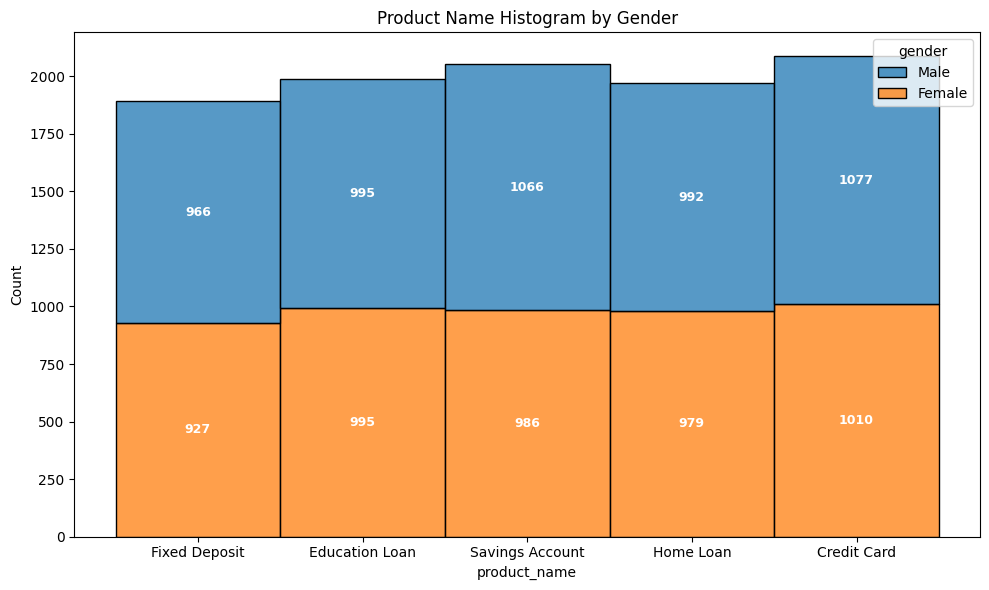

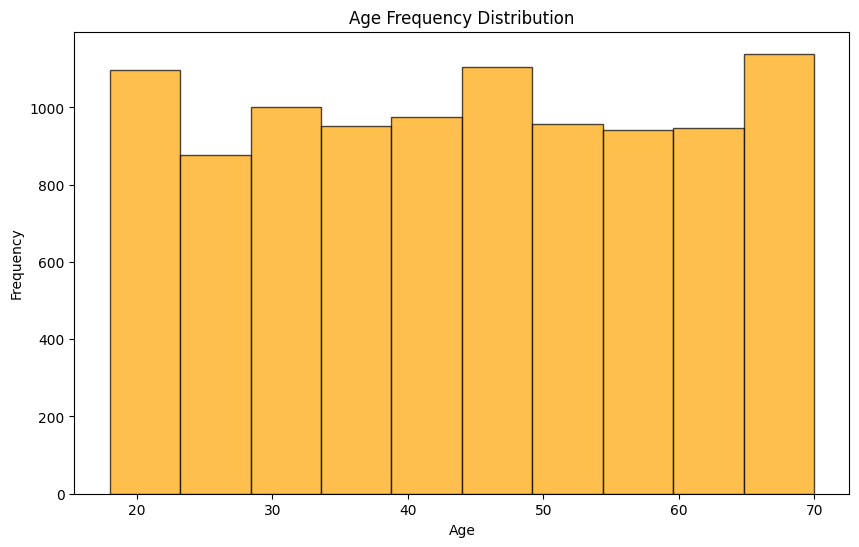

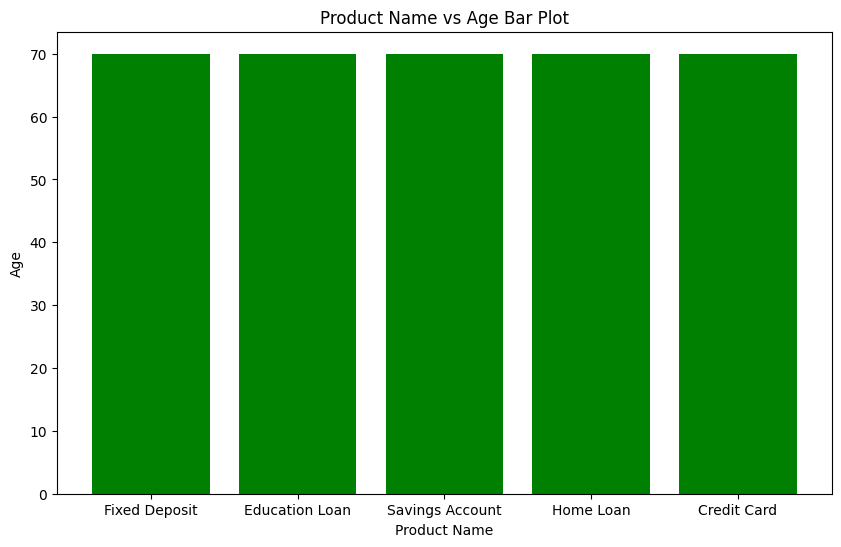

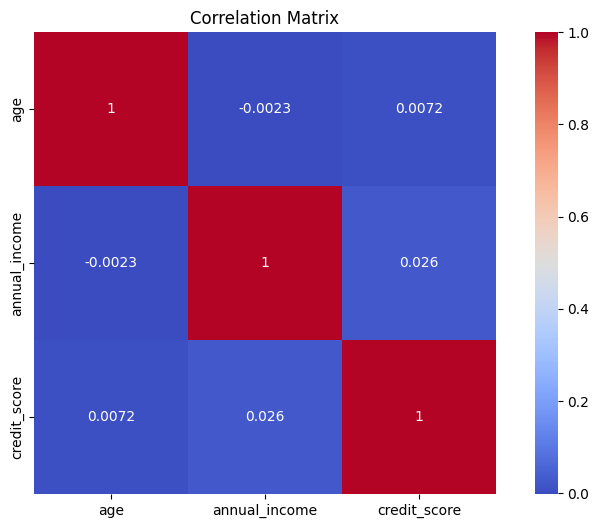

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [ ]:

try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    
    data_transformation.join_datasets()
    data_transformation.transform_data()
    data_transformation.split_data()
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    